In [1]:
# Preprocess simulation data from Claudio. This is used for training.
# Author Peter
import h5py
import numpy as np

#original = '/mnt/lts/nfs_fs02/sadow_lab/shared/gcr/data/proposal/download.hdf5' # Has info.
infile = '/mnt/lts/nfs_fs02/sadow_lab/shared/gcr/data/proposal/data.hdf5'
outfile = '/mnt/lts/nfs_fs02/sadow_lab/shared/gcr/data/proposal/data_processed.hdf5'

In [2]:
# Load, process, write data.
with h5py.File(infile, 'r') as f:
    print([k for k in f])
    print(f['info'])
    print(f['models'])
    dataset = f['models']
    # Remove events that have quality control flag.
    dataset = dataset[dataset['type'] == 0]
    
    X = np.vstack((dataset['alpha'], dataset['cmf'], dataset['cpa'], dataset['pwr1par'], dataset['pwr2par'], dataset['pwr1perr'], dataset['pwr2perr'])).T
    Y = np.array(dataset['flux'])
    
print(X.shape, Y.shape)

['info', 'models']
<HDF5 dataset "info": shape (1,), type "|V2102">
<HDF5 dataset "models": shape (1655808,), type "|V1018">
(1435308, 7) (1435308, 245)


In [5]:
# Shuffle data because simulations were not done in random order.
np.random.seed(0)
shuffle_indices = np.random.permutation(Y.shape[0])
X = X[shuffle_indices, :]
Y = Y[shuffle_indices]

# Write data to new file.
with h5py.File(outfile, 'w') as dest:
    dset = dest.create_dataset("X", data=X)
    X_MIN = np.min(X, axis=0) #np.array([20., 4.5, 50., 0.2, 0.2, 0.2, 0.2])
    X_MAX = np.max(X, axis=0) #np.array([75., 8.5, 250., 2., 2.3, 2., 2.3])
    X_RANGE = X_MAX - X_MIN
    dset = dest.create_dataset("X_minmax", data=(X-X_MIN)/X_RANGE)
    dset.attrs['X_MIN'] = X_MIN
    dset.attrs['X_MAX'] = X_MAX
    dset.attrs['X_RANGE'] = X_RANGE
    
    Y_logp1 = np.log(Y+1.)
    Y_logp1_MAX = np.max(Y_logp1) # Y_MAX = 8.268953
    Y_logp1_scaled = Y_logp1 / Y_logp1_MAX # Min should already be 0, and we want to emphasize the larger vals.
    dset = dest.create_dataset("Y", data=Y)
    dset = dest.create_dataset("Y_logp1", data=Y_logp1)
    dset = dest.create_dataset("Y_logp1_scaled", data=Y_logp1_scaled)
    dset.attrs['Y_logp1_MAX'] = Y_logp1_MAX
    

[ 41.094597    6.4734573 160.1557      1.0845096   1.3110111   1.1005557
   1.2972884] [18.050743    1.3014505  59.27727     0.59793526  0.67795295  0.599881
  0.6823871 ] [20.   4.5 50.   0.2  0.2  0.2  0.2] [ 75.    8.5 250.    2.    2.3   2.    2.3]


(array([[0.000000e+00, 0.000000e+00, 1.000000e+00, ..., 5.464190e+05,
         4.932610e+05, 2.740810e+05],
        [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 5.453890e+05,
         5.039230e+05, 2.689290e+05],
        [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 5.446950e+05,
         5.145740e+05, 2.630730e+05],
        ...,
        [1.435308e+06, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
         0.000000e+00, 0.000000e+00],
        [1.435308e+06, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
         0.000000e+00, 0.000000e+00],
        [1.435308e+06, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
         0.000000e+00, 0.000000e+00]]),
 array([5.9785582e-03, 8.3227605e-01, 1.6585735e+00, 2.4848709e+00,
        3.3111684e+00, 4.1374660e+00, 4.9637632e+00, 5.7900610e+00,
        6.6163583e+00, 7.4426560e+00, 8.2689533e+00], dtype=float32),
 <a list of 245 BarContainer objects>)

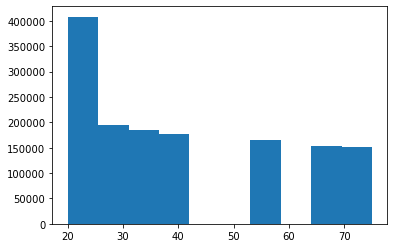

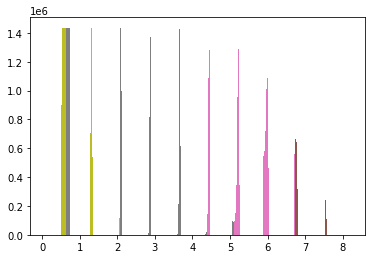

In [4]:
# Descriptive Statistics.
import matplotlib.pylab as plt
plt.figure(1)
plt.hist(X[:,0].flatten())
print(X[:].mean(axis=0), X[:].std(axis=0), X[:].min(axis=0), X[:].max(axis=0))


plt.figure(2)
logp1y = np.log(y+1.) # y has 245 dim.
plt.hist(logp1y)

In [1]:
# Example usage
import tensorflow as tf
import tensorflow_io as tfio # See https://stackoverflow.com/questions/60097970/tensorflow-io-dataset-input-pipeline-with-very-large-hdf5-files
BATCH_SIZE = 3
f = '/mnt/lts/nfs_fs02/sadow_lab/shared/gcr/data/proposal/data_processed.hdf5'
x = tfio.IODataset.from_hdf5(f, dataset='/features')
y = tfio.IODataset.from_hdf5(f, dataset='/flux')
full = tf.data.Dataset.zip((x, y)).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
train = full.take(np.floor(1435308/BATCH_SIZE *.6))
test = full.skip(np.floor(1435308/BATCH_SIZE *.6))

# Print 2 batches.
# for x, y in dataset.take(2).as_numpy_iterator():
#     print(x,y)

2021-10-24 14:08:36.489603: W tensorflow_io/core/kernels/audio_video_mp3_kernels.cc:271] libmp3lame.so.0 or lame functions are not available
2021-10-24 14:08:36.490022: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 AVX512F FMA
2021-10-24 14:08:38.547641: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-24 14:08:42.575466: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2021-10-24 14:08:42.575542: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localho

NameError: name 'tf' is not defined

119.660835

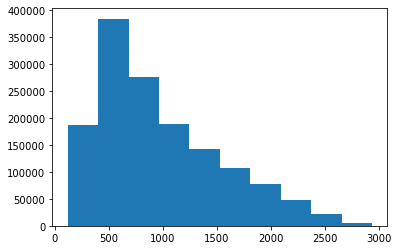

In [6]:
import matplotlib.pyplot as plt
plt.hist(Y[:, 10])
Y[:, 10].min()

In [26]:
f = '/mnt/lts/nfs_fs02/sadow_lab/personal/psadow/corti/data/data.hdf5'
with h5py.File(f) as h5:
    print([k for k in h5.keys()])
    info = h5['info'][:]
    models = h5['models'][:10]

['info', 'models']


In [43]:
for x in info[0]:
    #print()
    pass
    
len(info[0][-2])

245

In [51]:
info[0][-2]

array([  1.0001013,   1.022055 ,   1.0444907,   1.0674188,   1.0908501,
         1.1147959,   1.1392673,   1.1642759,   1.1898335,   1.215952 ,
         1.242644 ,   1.2699219,   1.2977985,   1.326287 ,   1.355401 ,
         1.385154 ,   1.4155602,   1.4466338,   1.4783896,   1.5108424,
         1.5440075,   1.5779008,   1.6125381,   1.6479356,   1.6841102,
         1.7210789,   1.7588592,   1.7974687,   1.8369257,   1.8772489,
         1.9184573,   1.9605702,   2.0036075,   2.0475898,   2.0925374,
         2.1384716,   2.185414 ,   2.2333872,   2.2824132,   2.3325157,
         2.3837178,   2.436044 ,   2.4895186,   2.5441673,   2.6000154,
         2.6570895,   2.7154164,   2.775024 ,   2.8359396,   2.898193 ,
         2.9618123,   3.0268285,   3.0932717,   3.1611736,   3.230566 ,
         3.3014817,   3.373954 ,   3.4480174,   3.5237062,   3.6010568,
         3.6801052,   3.760889 ,   3.843446 ,   3.9278152,   4.0140367,
         4.1021504,   4.1921988,   4.2842236,   4.3782687,   4.4